# Eye For Blind

## 1 Problem Statement
According to the World Health Organization (WHO), approximately 285 million people worldwide are visually impaired, and 39 million are completely blind. They have significant difficulty carrying out daily activities, reading, understanding images, etc.

The goal of this project is to create a deep learning model which can process an image, generate a text caption describing its contents and convert the text to speech to aid the visually impaired in understanding images.

## 2 Project Pipeline
The project is executed as per the following steps:
- Data Reading/Data Understanding
- Dataset Creation
- Model Building
- Model Training
- Model Evaluation
- Model Prediction

## 3 Data Reading/Data Understanding
Reading and understanding the data

### Importing necessary libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
import warnings
warnings.filterwarnings('ignore')


Setting random seeds so that results do not vary drastically

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

### Importing and extracting data

In [3]:
#!pip install -q kaggle
#from google.colab import files
#files.upload()
#!mkdir ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download 'adityajn105/flickr8k'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
#!mv flickr8k.zip '/content/drive/MyDrive/Colab Notebooks'
!mkdir flickr8k
!unzip -q '/content/drive/MyDrive/Colab Notebooks/flickr8k.zip' -d flickr8k

In [5]:
# Defining paths
CAPTIONS_PATH = '/content/flickr8k/captions.txt'
IMAGE_PATH = '/content/flickr8k/Images/'

### Reading the image paths into a variable

In [6]:
all_imgs = glob.glob(IMAGE_PATH + '/*.jpg',recursive=True)
print("Number of images in the dataset:",len(all_imgs))

Number of images in the dataset: 8091


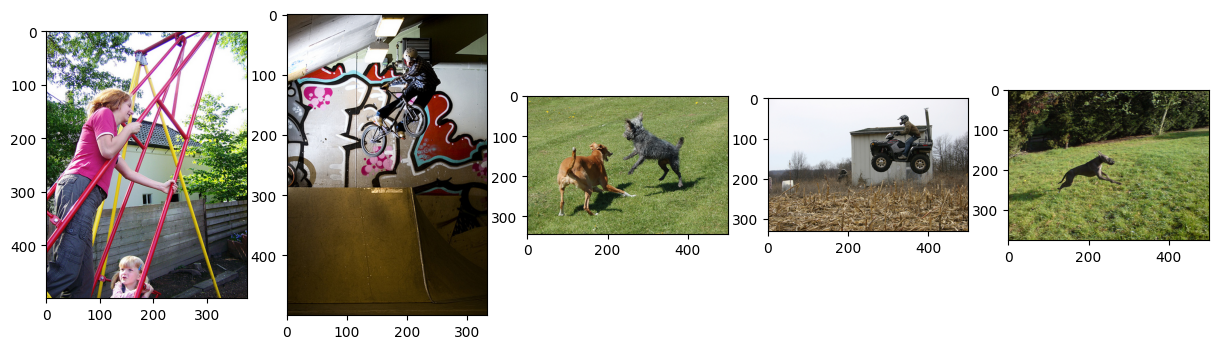

In [7]:
import imageio

#Visualising first 5 images :

Display_Images = all_imgs[:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(15)

for ax, im in zip(axes, Display_Images):
  ax.imshow(imageio.imread(im), cmap=None)


### Reading the captions into a variable

In [8]:
text_file = CAPTIONS_PATH

def load_doc(filename):
    
    open_file = open(text_file, 'r', encoding='latin-1' ) #returns a file object
    text = open_file.read() #reads contents of the file
    open_file.close()
    
    return text

doc = load_doc(CAPTIONS_PATH)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


### Creating a summary DataFrame of the images, paths and captions
Since each image has 5 captions associated with it, the dataset should have 40,455 samples

In [9]:
img_path = IMAGE_PATH

all_img_id = [] #store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

with open(CAPTIONS_PATH , 'r') as fo:
  next(fo) #to skip the heading
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                    Path  \
0      /content/flickr8k/Images/1000268201_693b08cb0e...   
1      /content/flickr8k/Images/1000268201_693b08cb0e...   
2      /content/flickr8k/Images/1000268201_693b08cb0e...   
3      /content/flickr8k/Images/1000268201_693b08cb0e...   
4      /content/flickr8k/Images/1000268201_693b08cb0e...   
...                                                  ...   
40450  /content/flickr8k/Images/997722733_0cb5439472.jpg   
40451  /content/flickr8k/Images/997722733_0cb5439472.jpg   
40452  /content/flickr8k/Images/997722733_0cb5439472.jpg   
40453  /content/flickr8k/Images/997722733_0cb5439472.jpg   
40454  /content/flickr8k/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [10]:
# Creating a list of all the captions and adding <start> & <end> tokens
annotations = df['Captions'].to_list()
annotations = ['<start> '+x+' <end>' for x in annotations]

# Creating a list which contains all image paths
all_img_path = df['Path'].to_list()

print("Number of captions in the dataset:",len(annotations))
print("Number of images present in the dataset:", len(set(all_img_path)))

Number of captions in the dataset: 40455
Number of images present in the dataset: 8091


Checking if all_img_path and all_img_vector has same values.

In [11]:
all_img_path[0]

'/content/flickr8k/Images/1000268201_693b08cb0e.jpg'

In [12]:
all_img_vector[0]

'/content/flickr8k/Images/1000268201_693b08cb0e.jpg'

In [13]:
annotations[0:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road  <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street  <end>',
 '<start> Two dogs of different breeds looking at each other on the road  <end>',
 '<start> Two dogs on pavement moving toward each other  <end>']

### Visualising the top 30 words in the captions

In [14]:
# Creating the vocabulary & a counter for the captions
vocabulary = []

# Converting all words into lowercase first to get proper values
vocabulary = [word.lower() for line in df['Captions'].to_list() for word in line.split()]

from collections import Counter
val_count = Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

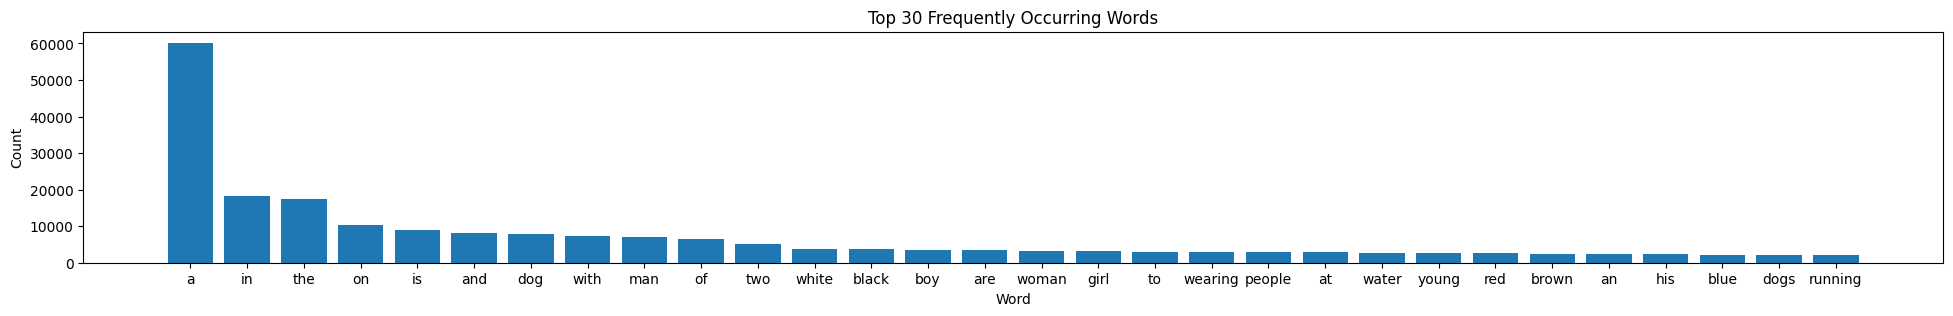

In [15]:
# Creating a bar plot

fig,ax = plt.subplots(figsize=(24,3))
x = [t[0] for t in val_count.most_common(30)]
y = [t[1] for t in val_count.most_common(30)]
ax.bar(x,y)
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.set_title('Top 30 Frequently Occurring Words')
fig.show()

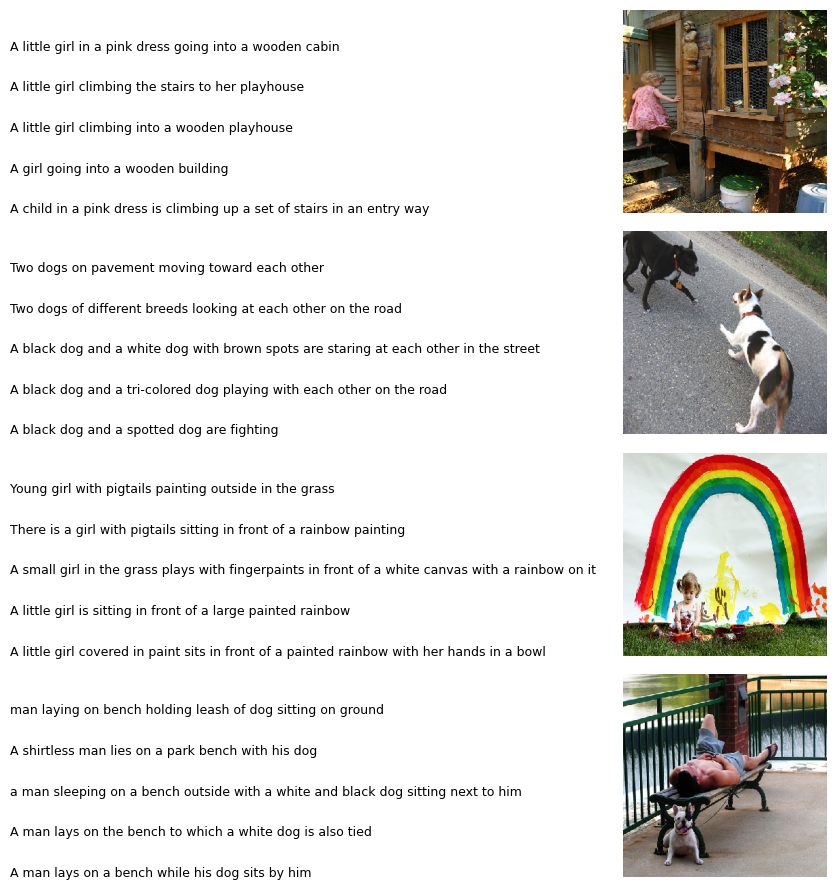

In [16]:
# visualize IMAGE and CAPTIONS together.

from tensorflow.keras.utils import load_img

fig = plt.figure(figsize=(9,9))         # For displaying image
cnt = 1
    
for Path in df[:20].Path.unique():        # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(4,2,cnt)         
    plt.axis('off')                       #remove x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))          #decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=9)   #display the captions         
    cnt = cnt + 1
    plt.tight_layout()                    #make sure that image and caption don't overlap

    ax = fig.add_subplot(4,2,cnt)
    ax.imshow(display_image)
    plt.axis('off')
    cnt = cnt + 1

plt.show()

## 4 Dataset Creation

### Preprocessing the captions

In [17]:
# Creating a tokenizer


num_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= num_word_cnt + 1,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='<unk>', lower = True, char_level =False )

# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

print('Text:',annotations[0])
print('Vector:',train_seqs[0])

Text: <start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>
Vector: [3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4]


In [18]:
print('OOV Token:',tokenizer.oov_token)

OOV Token: <unk>


In [19]:
# Creating word-to-index and index-to-word mappings
word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [20]:
# Deriving word counts from the tokenizer
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 61436),
             ('child', 1517),
             ('in', 18193),
             ('pink', 706),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 495),
             ('up', 1251),
             ('set', 106),
             ('of', 6504),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 51),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17677),
             ('to', 3008),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3641),
             ('dog', 7958),
             ('and', 8066),
             ('spotted', 37),
             ('are', 3365),
             ('fighting', 131),
             ('tri', 12),
             ('color

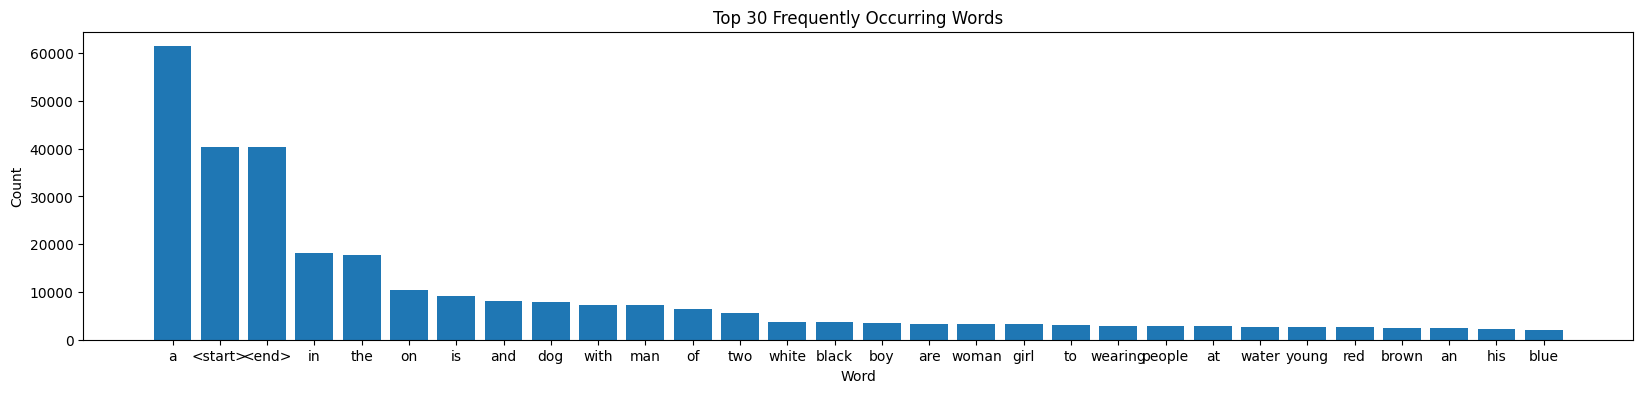

In [21]:
# Visualising the top 30 words after text processing
fig,ax = plt.subplots(figsize=(20,4))
x = sorted(tokenizer.word_counts,key = lambda x: tokenizer.word_counts[x],reverse=True)[:30]
y = sorted(tokenizer.word_counts.values(),reverse=True)[:30]
ax.bar(x,y)
ax.set_xlabel('Word')
ax.set_ylabel('Count')
ax.set_title('Top 30 Frequently Occurring Words')
fig.show()

In [22]:
# Padding each vector to make its length equal to that of the longest caption
max_cap_len = max(len(x) for x in train_seqs)
print("Length of the longest caption sequence:",max_cap_len)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_cap_len, dtype ='int32', value = 0)
print("Shape of caption tensor:",cap_vector.shape)

Length of the longest caption sequence: 35
Shape of caption tensor: (40455, 35)


### Preprocessing the images
Resizing the images into the shape (299, 299) and normalizing them within the range of -1 to 1, to bring them within the correct format for Inception v3.

Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


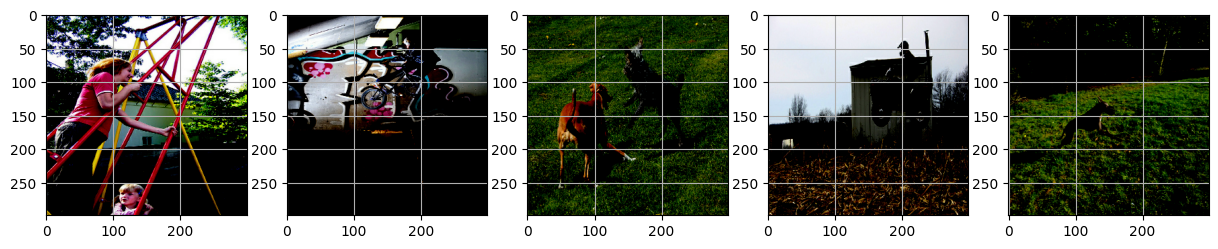

In [23]:
preprocessed_df = []

#checking image format 

tf.keras.backend.image_data_format()

# pre-processing of images to single size
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)

    # we need to decode jpeg encoded images (here by default channels = 0)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    #append preprocessed images to the list
    preprocessed_df.append(img)

# images post preprocessing

Display_Images = preprocessed_df[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(15)

for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

In [24]:
# Creating a dataset consisting of image paths
image_path_dataset = tf.data.Dataset.from_tensor_slices(all_imgs)

In [25]:
# Creating an function to resize and normalize the images
def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (299, 299))
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  return image,image_path

In [26]:
# Applying the function to the image path dataset, such that the transformed dataset contains images & their paths
image_dataset = image_path_dataset.map(load_image).batch(32)
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

### Loading Inception v3 with pretrained Imagenet weights
The features of images are extracted using the pre-trained model to prevent memory exhaustion and reduce computational time. The shape of the output is (batch_size, 8*8, 2048)

In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 5s 0us/step


In [28]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [29]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [30]:
# Applying the feature_extraction model to the image_dataset, reshaping the features in the format (batch_size, 8*8, 2048) and saving using np.save
for image, path in image_dataset:
  batch_features = image_features_extract_model(image)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
  
  for bf,p in zip(batch_features, path):
    feature_path = p.numpy().decode("utf-8")
    np.save(feature_path, bf.numpy())

### Creating the dataset
The dataset is created as per the following steps:
1. Application of train_test_split on both the image paths & captions to create the train & test lists
2. Creation of a function which maps the image paths to their features
3. Creation of a builder function to generate a dataset having features & captions using the image path & captions as input

In [31]:
# Applying train_test_split on the image paths & captions to create the train & test lists - 80:20 split

from sklearn.model_selection import train_test_split

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [32]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [33]:
# Creating a function which maps the image path to the corresponding feature
def map_func(image,caption):
  img_tensor = np.load(image.decode('utf-8')+'.npy')
  return img_tensor, caption

In [34]:
# Creating a builder function to generate a dataset having features & captions using the image paths & captions as input
def gen_dataset(path_list,cap_array,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((path_list, cap_array))

  # Mapping the image paths & captions to features and captions
  dataset = dataset.map(lambda item1,item2: tf.numpy_function(map_func, [item1,item2], [tf.float32, tf.int32]))

  # Shuffling and batching
  dataset = dataset.shuffle(1000).batch(batch_size)

  return dataset

In [35]:
BATCH_SIZE = 64

train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test,BATCH_SIZE)

In [36]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 35)


## 5 Model Building

In [37]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = len(path_train)//BATCH_SIZE
test_num_steps = len(path_test)//BATCH_SIZE

### Encoder
Defining the encoder which generates a feature vector for each image

In [38]:
from tensorflow.keras import Model

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = tf.keras.activations.relu(self.dense(features))
        return features

In [39]:
encoder=Encoder(embedding_dim)

### Attention model
Defining the attention model, which maps the feature vector output by the encoder to a context vector

In [40]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)          # Dense layer
        self.W2 = tf.keras.layers.Dense(units)          # Dense layer
        self.V = tf.keras.layers.Dense(1)               # Dense layer with 1 neuron
        self.units=units

    def call(self, features, hidden):
        # 'features' vector shape: (batch_size, 8*8, embedding_dim)
        # 'hidden' vector shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1)                                      # Changing the shape of the 'hidden' tensor to (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # Writing the score function with shape (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)               # Extracting attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features                                         # Creating the context vector with shape (batch_size, 8*8, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)                                # Reducing the shape to (batch_size, embedding_dim)
        return context_vector, attention_weights

### Decoder
Defining the decoder, which takes the contect vector as input and generates probabilities for the words in the vocabulary as output

In [41]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)                                               # Attention model
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)                     # Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') # Recurrent layer
        self.d1 = tf.keras.layers.Dense(units)                                                # Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)                                           # Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)                   # Creating the context vector & attention weights from the attention model
        embed = self.embed(x)                                                                 # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)                # Concatenating the input with the context vector from the attention layer. The shape is (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)                                                        # Extracting the output & hidden states from the GRU layer. The output shape is (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))                                    # Shape: (batch_size * max_length, hidden_size)
        output = self.d2(output)                                                              # Shape: (batch_size * max_length, vocab_size)
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [42]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [43]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print("Shape of 'Features' from Encoder: {}".format(features.shape)) # Shape: (batch_size , 8*8, embed_dim)
print("Shape of 'Predictions' from Decoder: {}".format(predictions.shape)) # Shape: (batch_size , vocab_size)
print("Shape of 'Attention Weights' from Decoder: {}".format(attention_weights.shape)) # Shape: (batch_size , 8*8, embed_dim)

Shape of 'Features' from Encoder: (64, 64, 256)
Shape of 'Predictions' from Decoder: (64, 5001)
Shape of 'Attention Weights' from Decoder: (64, 64, 1)


## 6 Model Training & Optimization

### Setting the optimizer & loss object

In [44]:
# Selecting Adam Optimizer

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Setting the checkpoint path

In [46]:
checkpoint_path = "./checkpoints/"
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [47]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

### Creating training & testing step functions

Teacher forcing is applied in the training step by passing the target 
word as the next input to the decoder instead of the previous prediction.

In [48]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions, hidden, _ = decoder(dec_input,features,hidden)
            loss = loss + loss_function(target[:,i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) # Using Teacher Forcing

    avg_loss = (loss / int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))    

    return loss, avg_loss

In the testing step, the previous prediction is passed as the next input to the decoder.

In [49]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions, hidden, _ = decoder(dec_input,features,hidden)
            loss = loss + loss_function(target[:,i], predictions)
            predicted_ind = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_ind, 1)

    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

### Creating a loss function for the test dataset

In [50]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    
    avg_test_loss = total_loss/test_num_steps

    return avg_test_loss

### Training the model

In [51]:
import time
from tqdm import tqdm

In [52]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('\nFor epoch: {}, the train loss is {:.3f} and test loss is {:.3f}.'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch is {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]


For epoch: 1, the train loss is 1.361 and test loss is 2.003.
Time taken for 1 epoch is 214.72387266159058 sec

Test loss has been reduced from 100.000 to 2.003


 13%|█▎        | 2/15 [05:34<34:27, 159.07s/it]


For epoch: 2, the train loss is 1.054 and test loss is 2.170.
Time taken for 1 epoch is 119.79054570198059 sec



 20%|██        | 3/15 [07:46<29:19, 146.59s/it]


For epoch: 3, the train loss is 0.956 and test loss is 2.048.
Time taken for 1 epoch is 131.72811675071716 sec



 27%|██▋       | 4/15 [09:53<25:26, 138.76s/it]


For epoch: 4, the train loss is 0.889 and test loss is 2.109.
Time taken for 1 epoch is 126.72951769828796 sec



 33%|███▎      | 5/15 [12:09<22:58, 137.89s/it]


For epoch: 5, the train loss is 0.833 and test loss is 2.129.
Time taken for 1 epoch is 136.33265233039856 sec



 40%|████      | 6/15 [14:47<21:40, 144.50s/it]


For epoch: 6, the train loss is 0.784 and test loss is 2.117.
Time taken for 1 epoch is 157.3273241519928 sec



 47%|████▋     | 7/15 [17:29<20:03, 150.39s/it]


For epoch: 7, the train loss is 0.739 and test loss is 2.167.
Time taken for 1 epoch is 162.47865509986877 sec



 53%|█████▎    | 8/15 [20:07<17:48, 152.67s/it]


For epoch: 8, the train loss is 0.698 and test loss is 2.180.
Time taken for 1 epoch is 157.54426050186157 sec



 60%|██████    | 9/15 [22:54<15:43, 157.30s/it]


For epoch: 9, the train loss is 0.659 and test loss is 2.254.
Time taken for 1 epoch is 167.46338868141174 sec



 67%|██████▋   | 10/15 [25:39<13:17, 159.54s/it]


For epoch: 10, the train loss is 0.623 and test loss is 2.302.
Time taken for 1 epoch is 164.5474705696106 sec



 73%|███████▎  | 11/15 [28:30<10:53, 163.25s/it]


For epoch: 11, the train loss is 0.589 and test loss is 2.394.
Time taken for 1 epoch is 171.63960146903992 sec



 80%|████████  | 12/15 [31:23<08:18, 166.04s/it]


For epoch: 12, the train loss is 0.558 and test loss is 2.425.
Time taken for 1 epoch is 172.412903547287 sec



 87%|████████▋ | 13/15 [34:14<05:34, 167.46s/it]


For epoch: 13, the train loss is 0.529 and test loss is 2.512.
Time taken for 1 epoch is 170.6902892589569 sec



 93%|█████████▎| 14/15 [37:13<02:51, 171.15s/it]


For epoch: 14, the train loss is 0.501 and test loss is 2.611.
Time taken for 1 epoch is 179.6719913482666 sec



100%|██████████| 15/15 [40:04<00:00, 160.31s/it]


For epoch: 15, the train loss is 0.475 and test loss is 2.686.
Time taken for 1 epoch is 170.84881114959717 sec



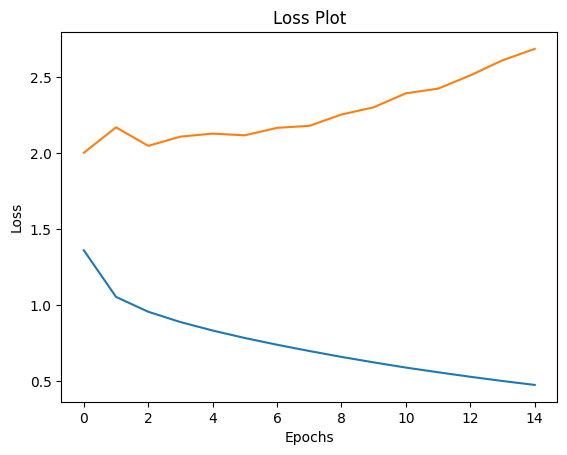

In [53]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

The test loss increases with the number of epochs while the train loss decreases because the train step, which uses teacher forcing, is different from the test step. Thus, the train and test losses cannot be compared directly and the trend doesn't indicate overfitting.

## 7 Model Evaluation

### Defining an evaluation function using greedy search

In [54]:
def evaluate(image):
    attention_plot = np.zeros((max_cap_len, 64))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) # Processing the input image before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extracting features using the feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # Extracting the features by passing the input to the encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_cap_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # Getting the output from the decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() # Extracting the id which carries the max value

        if tokenizer.index_word[predicted_id] == '<end>':
          return result, attention_plot, predictions
        else:
          result.append(tokenizer.index_word[predicted_id]) # Mapping the id to the word from the tokenizer and appending the value to the 'result' list
          dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

### Evaluating a sample image using greedy search

In [55]:
from PIL import Image

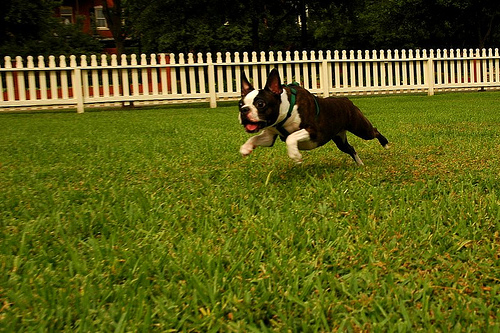


Caption: a black and white dog is running on the lawn


In [56]:
Image.open(all_img_vector[30]).show()
captions, attention_plot, predictions = evaluate(all_img_vector[30])
print('\nCaption:', ' '.join(captions))

### Defining functions to plot an attention map, generate a caption and calculate BLEU score given an image

In [57]:
from nltk.translate.bleu_score import sentence_bleu

In [58]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [59]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [60]:
!pip install gTTs
!pip install playsound
from gtts import gTTS
from playsound import playsound

from IPython import display

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=b56573be9aca1eaeed128a226b487ad534fba3bc2ea6e348f4801c70fac66f82
  Stored in directory: /root/.cache/pip/wheels/ba/39/54/c8f7ff9a88a644d3c58b4dec802d90b79a2e0fb2a6b884bf82
Successfully built playsound


In [61]:
def generate_caption(img_test, autoplay = False, weights=(0.5, 0.5, 0, 0)):
  cap_test_data = cap_test.copy()
  rid = np.random.randint(0, len(img_test))
  test_image = img_test[rid]

  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)

  real_caption=filt_text(real_caption)      

  pred_caption=' '.join(result)

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()

  score = sentence_bleu(reference, candidate, weights= weights)
  print(f"BELU score: {score*100}")

  print('Real Caption:', real_caption)
  print('Predicted Caption:', pred_caption)
  plot_attmap(result, attention_plot, test_image)

  # we will make use of Google Text to Speech API (online), which will convert the caption to audio
  speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
  speech.save('voice.mp3')
  audio_file = 'voice.mp3'

  display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

  print()
  Image.open(test_image).show()

  tts = gTTS("Predicted Caption: "+pred_caption, lang='en')
  tts.save('pred_caption.mp3')

## 8 Model Prediction
Generating captions for unseen images from the test dataset

##### Image 1

BELU score: 44.524513348388666
Real Caption: a black and brown dog wearing a red coat rolls in the snow
Predicted Caption: a black and black dog in a red jacket is laying in the snow


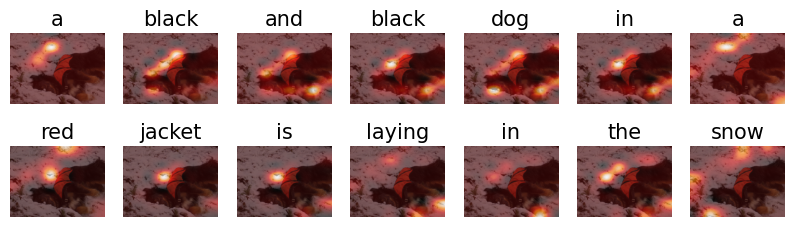

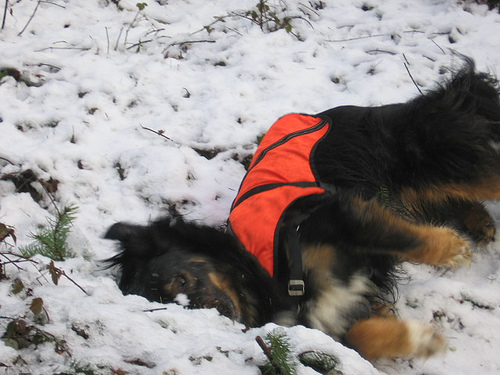

In [65]:
generate_caption(path_test, True, weights = (0.75, 0.5, 0, 0))

#### Image 2

BELU score: 58.85661912765424
Real Caption: two dogs run along a path strewn with dead leaves
Predicted Caption: two dogs run together down a walk through dead leaves


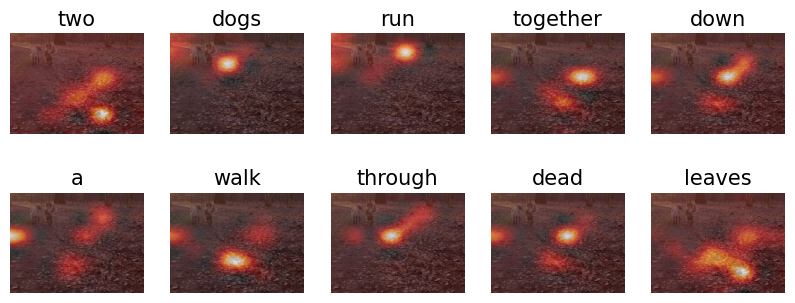

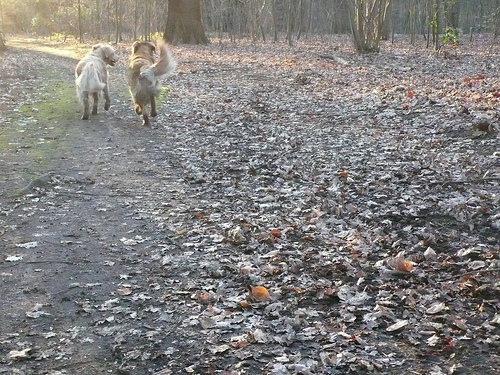

In [68]:
generate_caption(path_test, True, weights = (0.5, 0.25, 0, 0))

#### Image 3

BELU score: 66.37432104929863
Real Caption: a black dog with a red collar is jumping out of the water
Predicted Caption: black black dog with red collar is jumping through the water


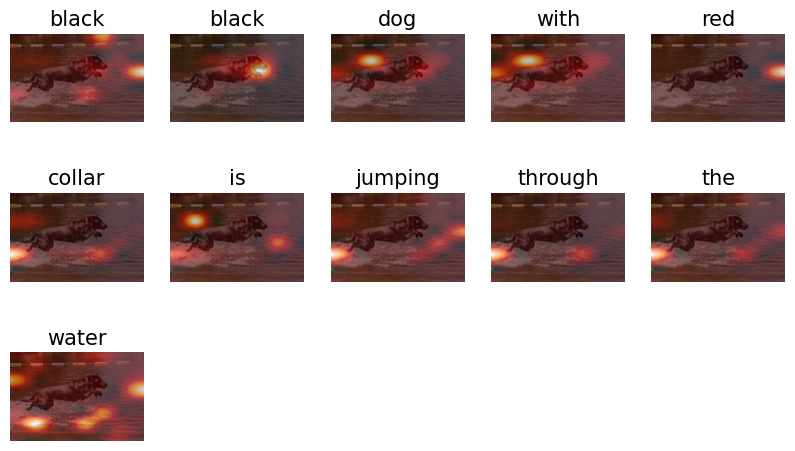

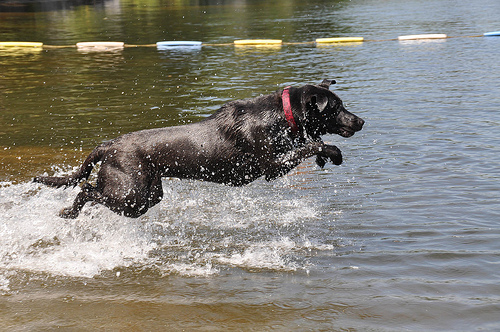

In [70]:
generate_caption(path_test, True, weights = (0.5, 0.25, 0, 0))

#### Image 4

BELU score: 6.143836690366871
Real Caption: a man runs after a cricket ball on a grass field
Predicted Caption: a man playing cricket


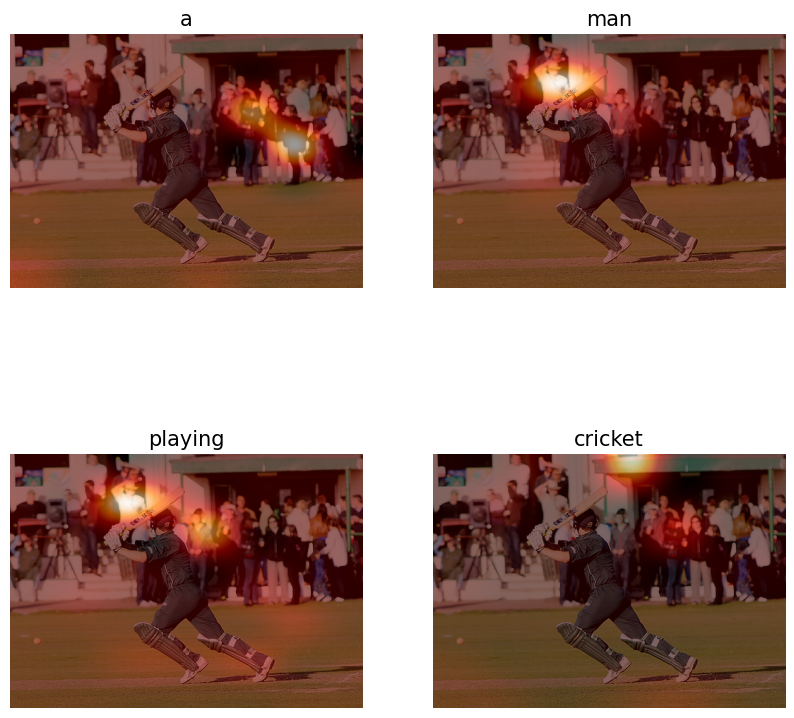

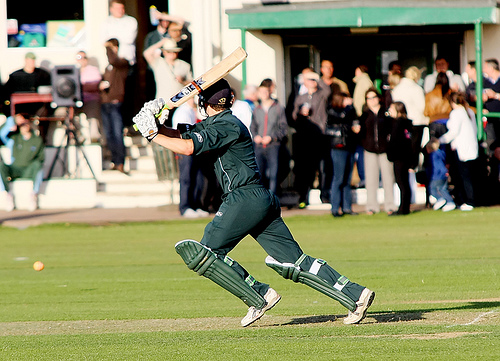

In [74]:
generate_caption(path_test, True, weights = (0.75, 0.75, 0, 0))

## 9 Summary

The project was done as per the steps outlined in section 2, 'Project Pilepine'.

Data Reading / Data Understanding involved reading the data, analysing and visualising it. The data was found to have 8091 images and 5 text captions describing each image.

Dataset creation involved preprocessing the captions and creating an embedded vector and preprocessing the images by resizing them to the shape (299,299) and normalizing to the range -1 to 1. The data was the split into training and testing sets in the ratio 80:20.

Inception v3, which is a CNN with excellent results in the Imagenet competition, was used to extract features from the images after removing the final softmax layer.

Model Building involved building a custom neural network containing an encoder, an attention model and a decoder. The image features generated by Inception v3 were passed to the encoder to generate a feature vector, which was passed to the attention model to generate a hidden context vector, and then to the decoder to generate a prediction vector. The predicton vector assigns a probability to each of the 5001 words in the vocabulary.

Model Training was done using the 'Adam' optimiser and the 'sparse categorical cross entropy' loss function and teacher forcing (passing target word insread of predicted word for generating the next prediction) was used during the training step.

Model Evaluation involved defining functions to generate a caption for an image using greedy search, and plot an attention map. Finally, model prediction involved generating captions for 3 unseen images from the test dataset and comparing them with an original caption using the BLEU score.